In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydicom
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 # Files

### First, let's see all files and folders in project directory

In [2]:
main_folder = '/kaggle/input/rsna-2023-abdominal-trauma-detection'

for i in os.listdir(main_folder):
    if os.path.isdir(os.path.join(main_folder, i)):
        print(f'{i} - directory')
    else:
        print(f'{i} - file')

train_dicom_tags.parquet - file
sample_submission.csv - file
train_series_meta.csv - file
train_images - directory
test_dicom_tags.parquet - file
segmentations - directory
train.csv - file
test_series_meta.csv - file
image_level_labels.csv - file
test_images - directory


### Then a quick glance at each file/directory

### train.csv

In [3]:
pd.read_csv(os.path.join(main_folder, "train.csv"))

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,9951,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,9960,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3144,9961,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,9980,1,0,1,0,1,0,0,1,0,0,0,0,1,1


Contains information about abdominal traumas for each patient, this is our target - we will analyze it in more detail in the next section


__________________________________________________________________________

### sample_submission.csv

In [4]:
pd.read_csv(os.path.join(main_folder, 'sample_submission.csv'))

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


This is how our submission should look like - for each patient we must predict probabilities of each injury.


___________________________________________________________

### train_images

In [5]:
train_images = os.listdir(os.path.join(main_folder, "train_images"))
print('train_images')
print(f'  -> {train_images[0]}')
for dir in os.listdir(os.path.join(main_folder, f'train_images/{train_images[0]}')):
    print(f'    -> {dir}')
    for img in os.listdir(os.path.join(main_folder, f'train_images/{train_images[0]}/{dir}'))[:10]:
        print(f'       -> {img}')
print(' ... ')

train_images
  -> 26501
    -> 22032
       -> 12.dcm
       -> 120.dcm
       -> 141.dcm
       -> 18.dcm
       -> 9.dcm
       -> 97.dcm
       -> 95.dcm
       -> 138.dcm
       -> 165.dcm
       -> 124.dcm
    -> 31614
       -> 120.dcm
       -> 97.dcm
       -> 95.dcm
       -> 124.dcm
       -> 116.dcm
       -> 96.dcm
       -> 71.dcm
       -> 45.dcm
       -> 64.dcm
       -> 109.dcm
 ... 


Directory contains computed tomography images of all patients, they have been grouped into folders named by patient id, each patient has been scanned once or twice, so in each patient's folder we have one or two folders named by scan id, these folders contain images in dcm format.

_____

### test_images

Same as train_images above, but patients here are not labeled, set as this will be used to evaluate our model.

___

### train_series_meta.csv

Each patient was scaned once or twice, these file connects patient id with scan id as well as volume of the aorta in hounsfield units on image, and information if there are any incomplete organs (organs croped on image)

In [6]:
tsm = pd.read_csv(os.path.join(main_folder, f'train_series_meta.csv'))
tsm

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0
...,...,...,...,...
4706,9961,2003,381.00,0
4707,9961,63032,143.75,0
4708,9980,40214,103.00,0
4709,9980,40466,135.00,0


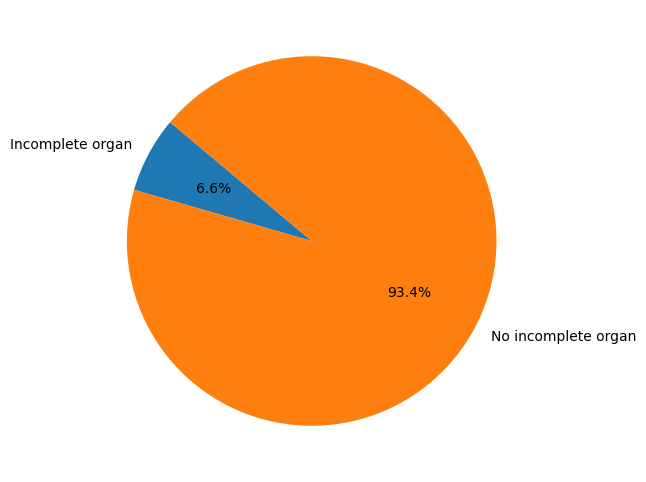

In [7]:
sizes = [tsm['incomplete_organ'].sum(), tsm['incomplete_organ'].count() - tsm['incomplete_organ'].sum()]
labels = ['Incomplete organ', 'No incomplete organ']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

___

### test_series_meta.csv

In [8]:
pd.read_csv(os.path.join(main_folder, f'test_series_meta.csv'))

,patient_id,series_id,aortic_hu
0,48843,295,401.25
1,48843,62825,238.00
2,50046,24574,149.00
3,50046,60658,352.00
4,63706,39279,219.00
5,63706,41385,319.00


Same as previous but for test set and no info about incomplete organs 

___

### segmentations

Model generated pixel-level annotations of the relevant organs and some major bones for a subset of the scans in the training set. 

___

### image_level_labels.csv

In [9]:
pd.read_csv(os.path.join(main_folder, f'image_level_labels.csv'))

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
12024,9632,3750,155,Active_Extravasation
12025,9632,3750,156,Active_Extravasation
12026,9632,3750,157,Active_Extravasation
12027,9632,3750,158,Active_Extravasation


Identifies specific images that contain either bowel or extravasation injuries.

___

### train_dicom_tags.parquet | test_dicom_tags.parquet

DICOM tags from every image, extracted with Pydicom.

___

# Target

In [10]:
train = pd.read_csv(os.path.join(main_folder, f'train.csv'))

Target contains information about injuries for each patient, total of 16 columns, bowel and extravasation traumas are split into two categories injury/healthy, whereas for kidney, liver and spleen ones there are three columns: healthy/low/high. The last column shows if the patient has any other injuries.


In [11]:
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)
memory usage: 368.9 KB


There is 3147 patients in total, fortunately no null values

#### How target is distributed? 

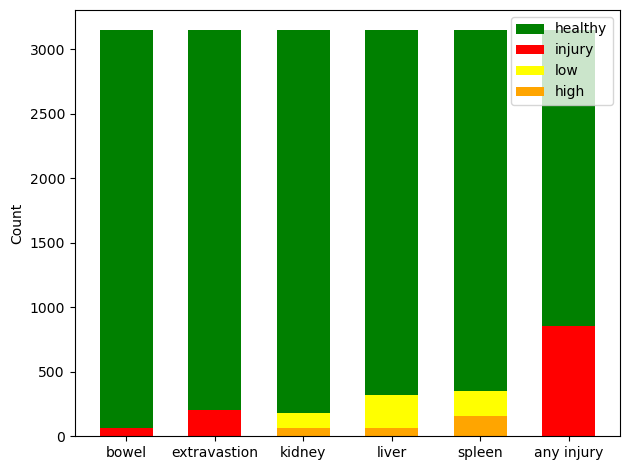

In [13]:
categories = ['bowel', 'extravastion', 'kidney', 'liver', 'spleen', 'any injury']
x = np.arange(len(categories))
fig, ax = plt.subplots()

ax.bar(x, [train['bowel_healthy'].count(), train['extravasation_healthy'].count(), 0, 0, 0, train['any_injury'].count()], width=0.6, label='healthy', color='green')
ax.bar(x, [train['bowel_injury'].sum(), train['extravasation_injury'].sum(), 0, 0, 0, 0], width=0.6, label='injury', color='red')
ax.bar(x, [0, 0, train['kidney_healthy'].count(), train['liver_healthy'].count(), train['spleen_healthy'].count(), 0], width=0.6, color='green')
ax.bar(x, [0, 0, train['kidney_low'].sum() + train['kidney_high'].sum(), train['liver_low'].sum() + train['liver_high'].sum(), train['spleen_low'].sum() + train['spleen_high'].sum(), 0], width=0.6, color='yellow', label='low')
ax.bar(x, [0, 0, train['kidney_high'].sum(), train['liver_high'].sum(), train['spleen_high'].sum(), 0], width=0.6, color='orange', label='high')
ax.bar(x, [0, 0, 0, 0, 0, train['any_injury'].sum()], width=0.6, color='red')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Count')
ax.set_title('')
ax.legend()

plt.tight_layout()
plt.show()

As we can see, there is a huge class imbalance, most of images shows healthy organs

#### Correlation between each injuries

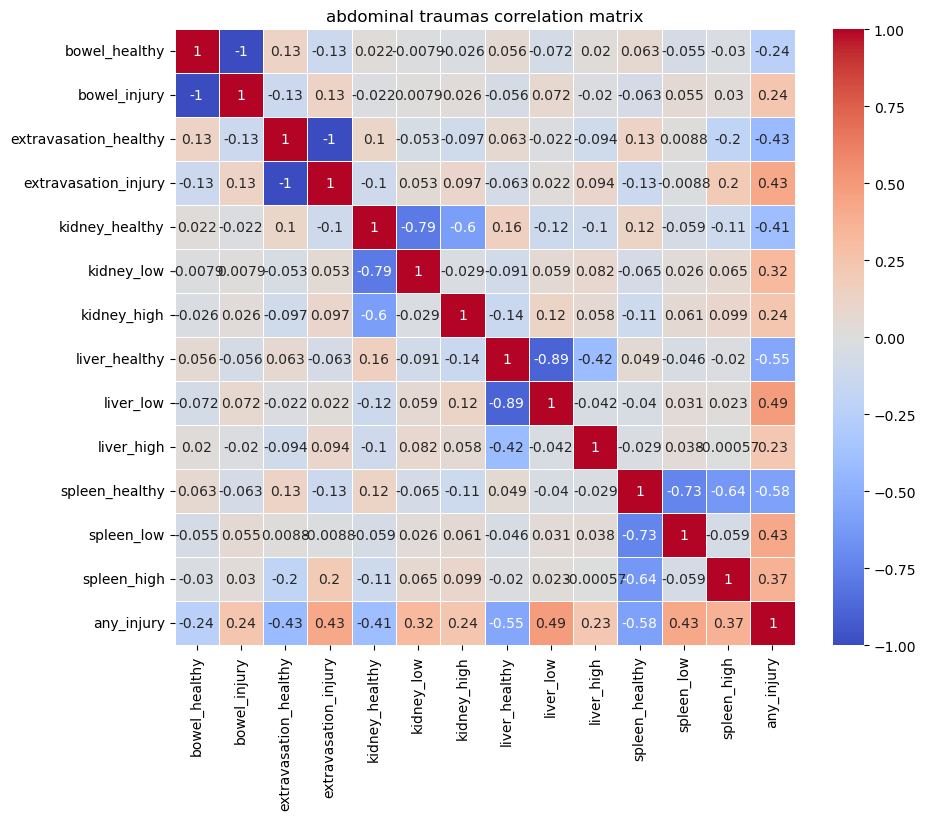

In [14]:
correlation_matrix = train.drop(columns=['patient_id']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('abdominal traumas correlation matrix')
plt.show()

# Images

First, let's see how sample images look like

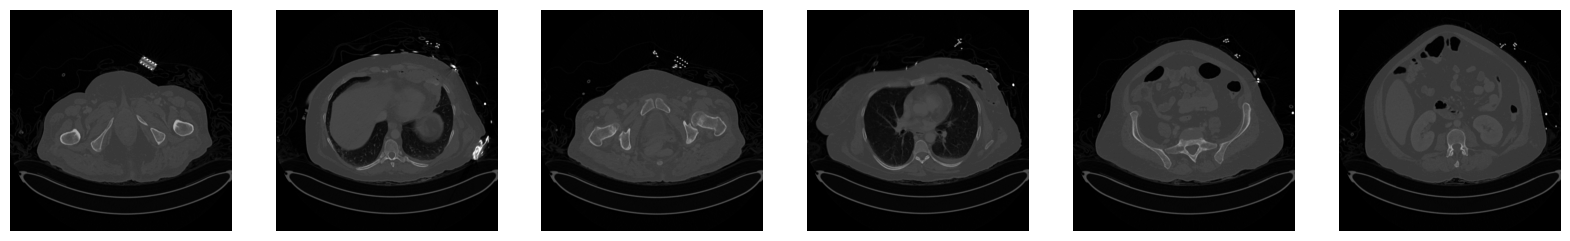

In [15]:
dicom_images = [pydicom.dcmread(os.path.join(main_folder, f'train_images/10004/21057/{dcm}')) for dcm in os.listdir(os.path.join(main_folder, 'train_images/10004/21057'))[:6]]

fig, axes = plt.subplots(1, len(dicom_images), figsize=(20, 10))

for i in range(6):
    axes[i].imshow(dicom_images[i].pixel_array, cmap='gray')
    axes[i].axis('off')

plt.show()

Each patient was scaned once or twice, what is proportion of 'one scan patients' to 'two scans patients'?

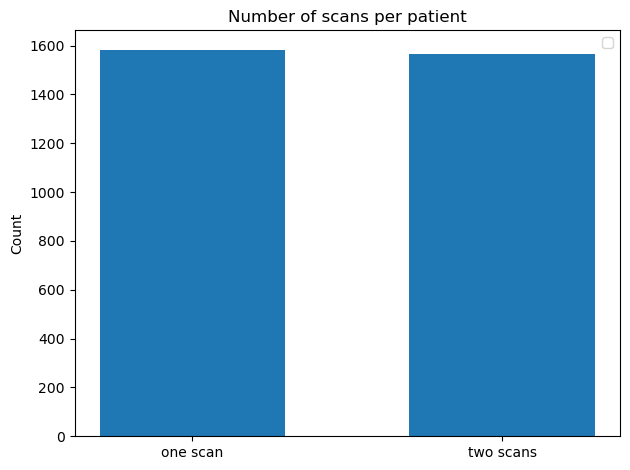

In [16]:
patient_ids = os.listdir(os.path.join(main_folder, 'train_images'))
one_scan = 0
two_scans = 0
for patient_id in patient_ids:
    num_scans = len(os.listdir(os.path.join(main_folder, f'train_images/{patient_id}')))
    if num_scans == 1:
        one_scan += 1
    elif num_scans == 2:
        two_scans += 1

categories = ['one scan', 'two scans']
x = np.arange(len(categories))
fig, ax = plt.subplots()

ax.bar(x, [one_scan, two_scans], width=0.6)

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Count')
ax.set_title('Number of scans per patient')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
num_images = 0
for patient_id in patient_ids:
    path = os.path.join(main_folder, f'train_images/{patient_id}')
    scan_ids = os.listdir(path)
    for scan_id in scan_ids:
        num_images += len(os.listdir(os.path.join(path, scan_id)))
num_images

1500653

There is total of 1500653 computed tomography images